In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import ruptures as rpt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

In [2]:
file_paths = list()
for country in os.listdir("data/country/"):
    if ".DS_Store" not in country:
        relative_path = os.getcwd() + "/data/country/" + str(country)
        file_paths.append(relative_path)
file_paths

['/Users/czhang/Desktop/PO-Tourism/data/country/Palau.csv',
 '/Users/czhang/Desktop/PO-Tourism/data/country/Nauru.csv',
 '/Users/czhang/Desktop/PO-Tourism/data/country/Marshall Islands (the).csv',
 '/Users/czhang/Desktop/PO-Tourism/data/country/Fiji.csv',
 '/Users/czhang/Desktop/PO-Tourism/data/country/Vanuatu.csv',
 '/Users/czhang/Desktop/PO-Tourism/data/country/Solomon Islands.csv',
 '/Users/czhang/Desktop/PO-Tourism/data/country/Tuvalu.csv',
 '/Users/czhang/Desktop/PO-Tourism/data/country/Micronesia (Federated States of).csv',
 '/Users/czhang/Desktop/PO-Tourism/data/country/Tonga.csv',
 '/Users/czhang/Desktop/PO-Tourism/data/country/Samoa.csv',
 '/Users/czhang/Desktop/PO-Tourism/data/country/Kiribati.csv',
 '/Users/czhang/Desktop/PO-Tourism/data/country/Papua New Guinea.csv']

In [32]:
def process_data(filepath,
                 variable_lst: list):

    df = (pd.read_csv(filepath)[
          variable_lst].reset_index().drop("index", axis=1))
    df["Date"] = pd.to_datetime(df["Date"])
    country = df["Country"][0]

    week_number = list()
    for idx in df.index:
        delta = (df["Date"][idx] - df["Date"][0]).days // 7
        week_number.append(delta)
    df["week"] = week_number
    return df, country


def detect_change(timeseries, model="rbf", pen=30):

    algo = rpt.Pelt(model=model).fit(timeseries)
    changes = algo.predict(pen=pen)
    return changes


def create_threshold(df: pd.DataFrame,
                     changes):
    covid_cutoff = df["Date"][changes[0]]
    covid_week = df[df.Date == covid_cutoff]["week"]
    df = df.assign(threshold=(df["Date"] > covid_cutoff).astype(int))
    print(covid_cutoff)
    
    return df


def plot_changes(df, x, y, ylabel, changes, name):
    sns.set(rc={'figure.figsize': (10, 6)})
    sns.set_style("whitegrid")
    g = sns.lineplot(data=df, x=x, y=y)
    for change in changes[:-1]:
        change_date = df["Date"][change]
        plt.axvline(change_date, lw=2, color='red', linestyle="--")

    plt.title(str(name))
    plt.xlabel("Date")
    plt.ylabel(str(ylabel))

    g.get_figure().savefig(str(name) + ".png", dpi=400)


def fit_model(df: pd.DataFrame,
              function_form: str):

    model = smf.wls(function_form, df).fit()
    df["fitted"] = model.fittedvalues
    df["resid"] = model.resid
    print(model.summary())


def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)


def plot_model(df, x, Y, yfit, hue):
    sns.set(rc={'figure.figsize': (10, 6)})
    sns.set_style("whitegrid")
    sns_reg = sns.scatterplot(data=df, x=x, y=Y, hue=hue)
    plt.legend(title='Dates', loc='upper right',
               labels=['Before Covid', 'During Covid'])
    sns.lineplot(data=df, x=x, y=yfit)
    plt.title("Test")

2020-03-21 00:00:00
                              WLS Regression Results                              
Dep. Variable:     Number_of_flights_intl   R-squared:                       0.943
Model:                                WLS   Adj. R-squared:                  0.943
Method:                     Least Squares   F-statistic:                     7558.
Date:                    Fri, 21 Oct 2022   Prob (F-statistic):               0.00
Time:                            13:16:22   Log-Likelihood:                -2707.2
No. Observations:                    1379   AIC:                             5422.
Df Residuals:                        1375   BIC:                             5443.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

2020-01-26 00:00:00
                              WLS Regression Results                              
Dep. Variable:     Number_of_flights_intl   R-squared:                       0.727
Model:                                WLS   Adj. R-squared:                  0.727
Method:                     Least Squares   F-statistic:                     1221.
Date:                    Fri, 21 Oct 2022   Prob (F-statistic):               0.00
Time:                            13:16:34   Log-Likelihood:                -4229.8
No. Observations:                    1379   AIC:                             8468.
Df Residuals:                        1375   BIC:                             8488.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

2020-01-11 00:00:00
                              WLS Regression Results                              
Dep. Variable:     Number_of_flights_intl   R-squared:                       0.811
Model:                                WLS   Adj. R-squared:                  0.810
Method:                     Least Squares   F-statistic:                     1962.
Date:                    Fri, 21 Oct 2022   Prob (F-statistic):               0.00
Time:                            13:16:44   Log-Likelihood:                -3253.5
No. Observations:                    1379   AIC:                             6515.
Df Residuals:                        1375   BIC:                             6536.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

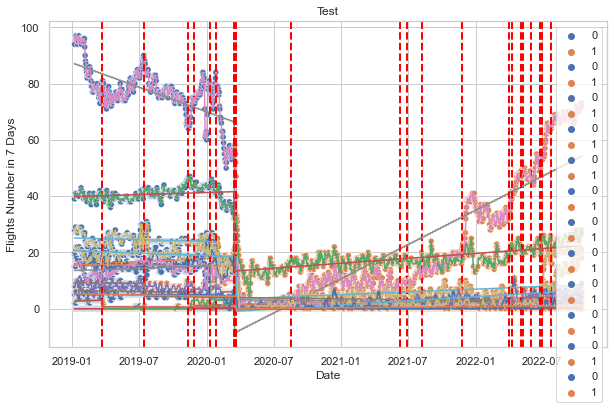

In [45]:
for path in file_paths:
    df, name = process_data(
        path, variable_lst=["Date", "Country", "Number_of_flights_intl"])
    df = pd.concat([df[["Date", "Country", "week"]], df[[
                   "Number_of_flights_intl"]].rolling(7).sum().fillna(0)], axis=1).iloc[6:]
    changes = detect_change(df[["Number_of_flights_intl"]])
    df = create_threshold(df, changes)
    plot_changes(df=df, x="Date", y="Number_of_flights_intl", ylabel="Flights Number in 7 Days",
                 changes=changes, name=name)
    fit_model(df, "Number_of_flights_intl ~ threshold + week + week * threshold")
    adf_test(df["resid"])
    plot_model(df, "Date", "Number_of_flights_intl", "fitted", "threshold")

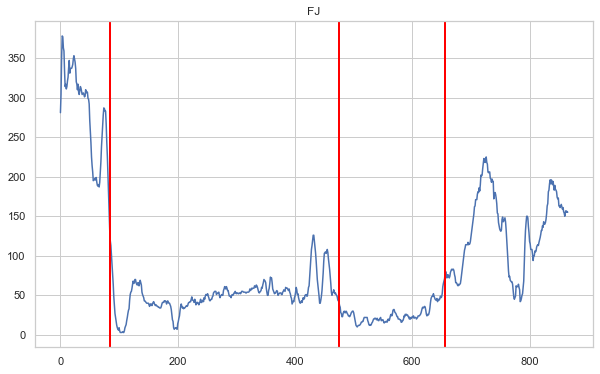

2020-03-26 00:00:00
FJ 
                              WLS Regression Results                             
Dep. Variable:     flights_number_7days   R-squared:                       0.759
Model:                              WLS   Adj. R-squared:                  0.758
Method:                   Least Squares   F-statistic:                     904.0
Date:                  Thu, 13 Oct 2022   Prob (F-statistic):          1.29e-265
Time:                          16:49:34   Log-Likelihood:                -4425.3
No. Observations:                   866   AIC:                             8859.
Df Residuals:                       862   BIC:                             8878.
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

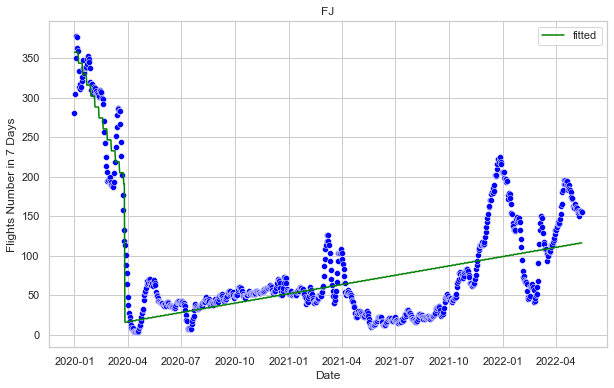

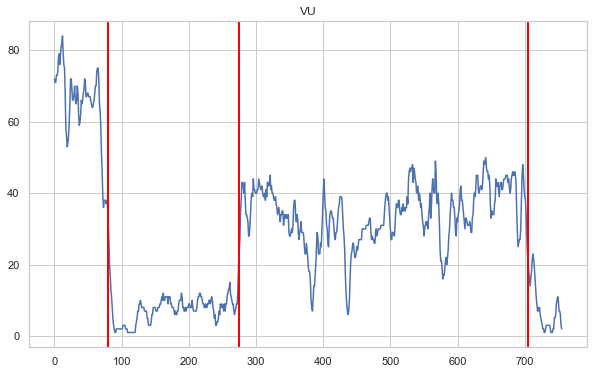

2020-03-21 00:00:00
VU 
                              WLS Regression Results                             
Dep. Variable:     flights_number_7days   R-squared:                       0.580
Model:                              WLS   Adj. R-squared:                  0.578
Method:                   Least Squares   F-statistic:                     345.6
Date:                  Thu, 13 Oct 2022   Prob (F-statistic):          5.28e-141
Time:                          16:49:35   Log-Likelihood:                -2966.4
No. Observations:                   756   AIC:                             5941.
Df Residuals:                       752   BIC:                             5959.
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

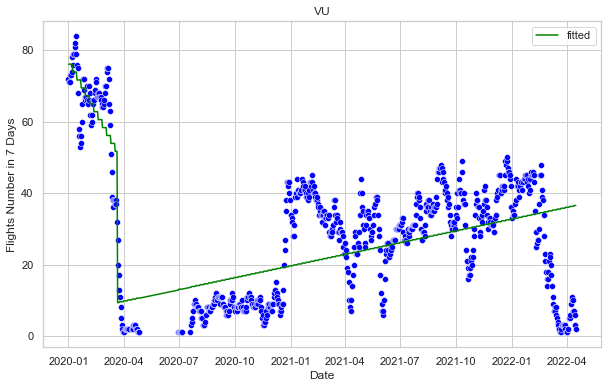

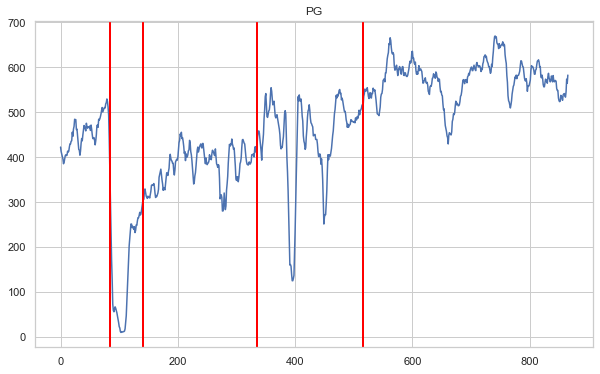

2020-03-26 00:00:00
PG 
                              WLS Regression Results                             
Dep. Variable:     flights_number_7days   R-squared:                       0.641
Model:                              WLS   Adj. R-squared:                  0.639
Method:                   Least Squares   F-statistic:                     512.2
Date:                  Thu, 13 Oct 2022   Prob (F-statistic):          5.33e-191
Time:                          16:49:36   Log-Likelihood:                -5001.5
No. Observations:                   866   AIC:                         1.001e+04
Df Residuals:                       862   BIC:                         1.003e+04
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

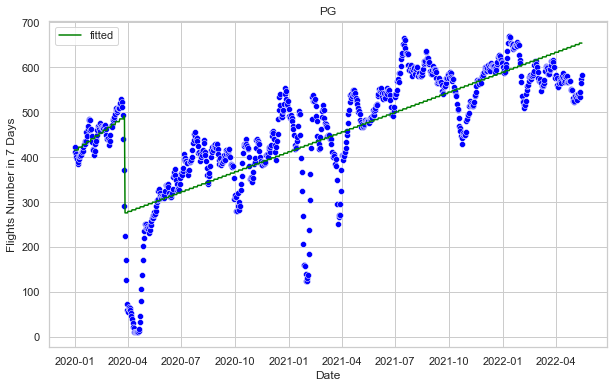

In [76]:
for path in file_paths[4:7]:

    df = (pd.read_csv(path)[["destination_iso_country", "date", "flights_number_7days"]]
            .reset_index().drop("index", axis=1))
    df["date"] = pd.to_datetime(df["date"])
    country = df["destination_iso_country"][0]

    week_number = list()
    for idx in df.index:
        delta = (df["date"][idx] - df["date"][0]).days // 7
        week_number.append(delta)
    df["week"] = week_number
    df.to_csv("data/ts/"+str(country)+"_ts.csv")

    ts = df[["flights_number_7days"]]
    algo = rpt.Pelt(model="rbf").fit(ts)
    changes = algo.predict(pen=30)

    # Multiple cutoff points
    plt.figure(figsize=(10, 6))
    plt.plot(ts)
    for change in changes[:-1]:
        plt.axvline(change, lw=2, color='red')

    plt.title(country)
    plt.show()

    covid_cutoff = df["date"][changes[0]]
    print(covid_cutoff)
    covid_week = df[df.date == covid_cutoff]["week"]
    df = df.assign(threshold=(df["date"] > covid_cutoff).astype(int))
    df["week_t"] = df["week"] - int(covid_week)

    # Simple RDiT model
    model = smf.wls(
        "flights_number_7days ~ threshold + week + week * threshold", df).fit()
    df["fitted"] = model.fittedvalues
    df["resid"] = model.resid
    print(country, "\n", model.summary())
    adf_test(df["resid"])

    # RDiT Graph
    sns.set(rc={'figure.figsize': (10, 6)})
    sns.set_style("whitegrid")
    sns.scatterplot(x="date", y="flights_number_7days", data=df, color="blue")
    sns.lineplot(x="date", y="fitted", data=df,
                 color="green", label="fitted")
    plt.xlabel("Date")
    plt.ylabel("Flights Number in 7 Days")
    plt.title(country)
    plt.savefig("Viz/rdd_" + str(country.lower()) + ".png", dpi=400)